In [1]:
import os
import glob
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_curve, confusion_matrix
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Softmax, Activation, Dense, Dropout


class Group14:
    def __init__(self, sys='/', path=None, random_state=42):
        """
        Initialize model
        :param sys: system type, "\\" for windows and "/" for mac
        :param path: working dictionary
        :param random_state: random state
        """
        # change working dictionary
        if path:
            os.chdir(path)

        # check the existence of images
        assert len(glob.glob('Images')) == 1, 'Images not found in current working dictionary'

        self.sys = sys
        self.random_state = random_state

    def check(self):
        """
        Convert to 'jpeg' type file
        :return: nothing
        """
        image_filenames = glob.glob(".{0}Images{0}n02*{0}*.jpg".format(self.sys))
        for path in image_filenames:
            if imghdr.what(path) == 'jpeg':
                pass
            else:
                img = Image.open(path)
                rgb_im = img.convert('RGB')
                rgb_im.save(path, 'JPEG')

    def information(self, sample_size=None):
        """
        Get the information of images
        :return: file names and breed names
        """
        if hasattr(self, "_files") and self._files is not None:
            return self._files, self._breeds, self._breed_index

        files = glob.glob(".{0}Images{0}n02*{0}*.jpg".format(self.sys))
        if sample_size:
            files = random.sample(files, sample_size)
        breeds = [item.split(self.sys)[-1][10:] for item in glob.glob(".{0}Images{0}n02*".format(self.sys))]
        n = len(files)  # sample size
        p = len(breeds)  # number of classes

        # build index dictionary for each breed
        breed_index = dict()
        for i in range(len(breeds)):
            breed_index[breeds[i]] = i

        self._files = files
        self._breeds = breeds
        self._breed_index = breed_index
        self._n = n
        self._p = p
        return files, breeds, breed_index

    def load_data(self, test_size=0.3, standard_size=(224, 224), normal=255):
        """
        Load dataset and separate into training set and testing set
        :param test_size: size of testing set
        :param standard_size: image shape
        :param normal: normalize images to 0-1
        :return: split dataset, including x_train, x_test, y_train and y_test
        """
        if hasattr(self, "_x_train") and self._x_train is not None:
            return self._x_train, self._x_test, self._y_train, self._y_test

        files, breeds, breed_index = self.information()
        n = len(files)

        # initialize dataset
        x = np.zeros((n, 224, 224, 3))
        y = np.zeros((n, ), dtype='int')

        # load data
        for i in range(n):
            file = files[i]
            breed = file.split(self.sys)[2][10:]
            y[i] = breed_index[breed]
            img = Image.open(file).resize(standard_size)
            x[i] = np.array(img) / normal

        # separate training set and testing set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=self.random_state)

        self._x_train = x_train
        self._x_test = x_test
        self._y_train = y_train
        self._y_test = y_test
        return x_train, x_test, y_train, y_test

    def get_model(self):
        """
        Initialize model and training history
        :return: dictionary of model and training history
        """
        if hasattr(self, "_model") and self._model is not None:
            return self._model, self._history

        model = dict()
        history = dict()

        self._model = model
        self._history = history
        self._model_names = ['MLP', 'InceptionV3', 'ResNet50', 'MobileNet']
        return model, history

    def get_pre(self):
        """
        Initialize model evaluation
        :return: dictionary of model probability and prediction
        """
        if hasattr(self, "_model_prob") and self._model_prob is not None:
            return self._model_prob, self._model_pre

        model_prob = dict()
        model_pre = dict()

        self._model_prob = model_prob
        self._model_pre = model_pre
        return model_prob, model_pre

    def fit(self, model_name, epochs=15, validation_split=0.1, input_shape=(224, 224, 3)):
        """
        Fit model
        :param model_name: model name
        :param epochs: epochs
        :param validation_split: size of the validation set
        :return: trained model and fitting history of the model
        """
        if hasattr(self, "_model") and model_name in self._model:
            return self._model[model_name], self._history[model_name]

        x_train, x_test, y_train, y_test = self.load_data()
        model, history = self.get_model()

        # initialize model
        if model_name == 'MLP':
            model[model_name] = self.model_build_MLP(input_shape=input_shape)
        elif model_name == 'ResNet50':
            model[model_name] = self.model_build_ResNet50()
        elif model_name == 'InceptionV3':
            model[model_name] = self.model_build_InceptionV3(input_shape=input_shape)
        elif model_name == 'MobileNet':
            model[model_name] = self.model_build_MobileNet()
        else:
            print('No model named {}'.format(model_name))
            return

        # do the training
        tmp = model[model_name].fit(x_train, y_train, epochs=epochs, validation_split=validation_split)
        history[model_name] = tmp.history

        # save model and training history
        model[model_name].save(model_name)
        with open('history_' + model_name + '.txt', 'wb') as f:
            pickle.dump(history[model_name], f)

        self._model = model
        self._history = history
        return model[model_name], history[model_name]

    def load_model(self, model_name):
        """
        Load saved model
        :param model_name: model name
        :return: trained model and fitting history of the model
        """
        if hasattr(self, "_model") and model_name in self._model:
            return self._model[model_name], self._history[model_name]

        model, history = self.get_model()
        model[model_name] = load_model(model_name)
        with open('history_' + model_name + '.txt', 'rb') as f:
            history[model_name] = pickle.load(f)

        self._model = model
        self._history = history
        return model[model_name], history[model_name]

    def training_plot(self, model_name):
        """
        Plot training & validation accuracy values
        :param model_name: model name
        :param figsize: figure size of the plot
        :param model_name: dpi of the plot
        :return: None
        """
        model, history = self.get_model()
        if model_name not in model:
            print('No trained model named '.format(model_name))
            return

        fig, ax = plt.subplots()
        ax.plot(history[model_name]['accuracy'])
        ax.plot(history[model_name]['val_accuracy'])
        ax.set_title('Model accuracy of {}'.format(model_name))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')

        plt.tight_layout()
        plt.savefig('Training process of {}'.format(model_name), dpi=1080)

    def model_evaluate(self, model_name):
        """
        Evaluate the model performance
        :param model_name: model name
        :return: classification result
        """
        model, history = self.get_model()
        if model_name not in model:
            print('No trained model named '.format(model_name))
            return
        files, breeds, breed_index = self.information()
        x_train, x_test, y_train, y_test = self.load_data()
        y_prob, y_pre = self.get_pre()
        if model_name in y_pre:
            return y_pre[model_name]

        n_test = y_test.shape[0]
        p = len(breeds)
        y_prob[model_name] = model[model_name].predict(x_test)
        y_pre[model_name] = np.zeros(y_test.shape)
        for i in range(n_test):
            y_pre[model_name][i] = np.argmax(y_prob[model_name][i][:p])

        self._model_prob = y_prob
        self._model_pre = y_pre
        return y_pre[model_name]

    def result(self):
        """
        Calculate evaluation score of each model and each breed
        :return: dataframe of the score
        """
        if hasattr(self, "_model_result") and self._model_result is not None:
            return self._model_pre, self._model_result, self._breed_result

        files, breeds, breed_index = self.information()
        x_train, x_test, y_train, y_test = self.load_data()
        y_prob, y_pre = self.get_pre()
        model_names = self._model_names
        p = len(breeds)
        n_test = y_test.shape[0]
        score = ['accuracy', 'precision', 'recall', 'f1']

        model_pre = pd.DataFrame(np.zeros((n_test, len(model_names) + 1)), columns=['True'] + model_names)
        model_result = pd.DataFrame(np.zeros((len(model_names), len(score))), columns=score, index=model_names)
        breed_result = dict()
        model_pre.iloc[:, 0] = y_test
        for i, name in enumerate(model_names):
            # prediction value
            model_pre.iloc[:, i + 1] = y_pre[name]

            # score for each model
            model_result.iloc[i, 0] = accuracy_score(y_test, y_pre[name])
            model_result.iloc[i, 1] = precision_score(y_test, y_pre[name], average='micro', zero_division=1)
            model_result.iloc[i, 2] = recall_score(y_test, y_pre[name], average='micro', zero_division=1)
            model_result.iloc[i, 3] = f1_score(y_test, y_pre[name], average='micro', zero_division=1)

            # score for each breed
            breed_result[name] = pd.DataFrame(np.zeros((p + 1, len(score))), columns=score, index=['total'] + breeds)
            breed_result[name].iloc[0, 0] = accuracy_score(y_test, y_pre[name])
            breed_result[name].iloc[0, 1] = precision_score(y_test, y_pre[name], average='weighted', zero_division=1)
            breed_result[name].iloc[0, 2] = recall_score(y_test, y_pre[name], average='weighted', zero_division=1)
            breed_result[name].iloc[0, 3] = f1_score(y_test, y_pre[name], average='weighted', zero_division=1)
            breed_result[name].iloc[1:, 0] = jaccard_score(y_test, y_pre[name], average=None, zero_division=1)[:p]
            breed_result[name].iloc[1:, 1] = precision_score(y_test, y_pre[name], average=None, zero_division=1)[:p]
            breed_result[name].iloc[1:, 2] = recall_score(y_test, y_pre[name], average=None, zero_division=1)[:p]
            breed_result[name].iloc[1:, 3] = f1_score(y_test, y_pre[name], average=None, zero_division=1)[:p]

            # save as csv file
            breed_result[name].to_csv('score of each breed in model {}.csv'.format(name))

            # plot TOP-30 misclass breed pairs
            tmp = pd.DataFrame({'actual':y_test, 'pred':y_pre[name], 'count':np.ones((n_test, ))}, dtype='int')
            for j in range(n_test):
                tmp.loc[j, 'actual'] = breeds[tmp.loc[j, 'actual']]
                tmp.loc[j, 'pred'] = breeds[tmp.loc[j, 'pred']]
            
            misclass = tmp[tmp['actual'] != tmp['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()
            misclass['pair'] = misclass['actual'] + ' / ' + misclass['pred']
            misclass = misclass[['pair', 'count']].take(range(30))
            
            fig, ax = plt.subplots(figsize=(18, 10))
            misclass.sort_values(['count']).plot.barh(ax=ax, x='pair')
            ax.set_title('TOP-30 misclass breed pairs for {} model'.format(name))
            plt.tight_layout()
            plt.savefig('TOP-30 misclass breed pairs for {} model'.format(name), dpi=1080)

        model_pre.to_csv('prediction for each model.csv')
        model_result.to_csv('score for each model.csv')

        self._model_pre = model_pre
        self._model_result = model_result
        self._breed_result = breed_result
        return model_pre, model_result, breed_result

    def roc_plot(self, breed_name):
        """
        ROC curve of one breed classification result
        :param breed_name: breed name
        :param figsize: figure size of the plot
        :param dpi: dpi of the plot
        :return: None
        """
        files, breeds, breed_index = self.information()
        x_train, x_test, y_train, y_test = self.load_data()
        y_prob, y_pre = self.get_pre()
        model_names = self._model_names

        if breed_name not in breed_index:
            print('Unknown breed')
            return
        index = breed_index[breed_name]

        fig, ax = plt.subplots()
        ax.plot([0, 1], [0, 1], 'k--')

        for name in model_names:
            y_score = y_prob[name][:, index]
            fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=index)
            ax.plot(fpr, tpr, label=name)

        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
        ax.set_title('ROC curve of {}'.format(breed_name))
        ax.legend(loc='best')

        plt.tight_layout()
        plt.savefig('ROC curves of {}'.format(breed_name), dpi=1080)

    def model_build_MLP(self, input_shape=(224, 224, 3)):
        """
        Build MLP model
        :param input_shape: image shape
        :return: MLP model
        """
        if hasattr(self, "_model_MLP") and self._model_MLP is not None:
            return self._model_MLP

        files, breeds, breed_index = self.information()
        p = len(breeds)
        
        model_MLP = keras.models.Sequential()
        model_MLP.add(Flatten(input_shape=input_shape))
        model_MLP.add(Dense(3000, activation="relu"))
        model_MLP.add(Dense(1000, activation="relu"))
        model_MLP.add(Dense(p, activation="softmax"))
        model_MLP.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

        self._model_MLP = model_MLP
        return model_MLP

    def model_build_InceptionV3(self, input_shape=(224, 224, 3)):
        """
        Build inceptionV3 model
        :return: inceptionV3 model
        """
        if hasattr(self, "_model_InceptionV3") and self._model_InceptionV3 is not None:
            return self._model_InceptionV3

        files, breeds, breed_index = self.information()
        p = len(breeds)

        tmp = keras.applications.InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
        model_InceptionV3 = Sequential()

        for layer in tmp.layers:
            layer.trainable = False

        model_InceptionV3.add(tmp)
        model_InceptionV3.add(GlobalAveragePooling2D())
        model_InceptionV3.add(Dropout(0.2))
        model_InceptionV3.add(Flatten())
        model_InceptionV3.add(Dense(128, activation="relu"))
        model_InceptionV3.add(Dense(64, activation="relu"))
        model_InceptionV3.add(Dense(p, activation='softmax'))

        model_InceptionV3.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

        self._model_InceptionV3 = model_InceptionV3
        return model_InceptionV3

    def model_build_ResNet50(self):
        """
        Build pre-trained ResNet50 model
        :return: pre-trained ResNet50 model
        """
        if hasattr(self, "_model_ResNet50") and self._model_ResNet50 is not None:
            return self._model_ResNet50

        model_ResNet50 = keras.applications.resnet50.ResNet50(weights="imagenet")
        model_ResNet50.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

        self._model_ResNet50 = model_ResNet50
        return model_ResNet50

    def model_build_MobileNet(self):
        """
        Build pre-trained MobileNet model
        :return: pre-trained MobileNet model
        """
        if hasattr(self, "_model_MobileNet") and self._model_MobileNet is not None:
            return self._model_MobileNet

        model_MobileNet = keras.applications.mobilenet.MobileNet(weights="imagenet")
        model_MobileNet.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

        self._model_MobileNet = model_MobileNet
        return model_MobileNet

    def confusion_plot(self, model_name):
        files, breeds, breed_index = self.information()
        x_train, x_test, y_train, y_test = self.load_data()
        y_pre = self.model_evaluate(model_name)

        confusion = confusion_matrix(y_test, y_pre)

        fig, ax = plt.subplots(figsize=(18, 18))
        sns.heatmap(confusion, ax=ax, yticklabels=breeds, xticklabels=breeds, robust=True)
        ax.set_title("Heatmap of the confusion matrix of {} model".format(model_name))
        
        fig.tight_layout()
        plt.savefig("Confusion matrix heatmap for {} model".format(model_name), dpi=1080)


# Preprocessing

Here we import Standford dogs dataset from TFDS, and it has been splited into train set and test set already, for more information about the data set you can find https://www.tensorflow.org/datasets/catalog/stanford_dog.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import Sequential
from keras.layers.experimental import preprocessing
from keras.layers.core import Reshape

In [3]:
# set working dictionary
import os
# path = 'D:\\Study\\Cardiff\\CMT307 Applied Machine Learning\\lab\\Coursework_2_0514ddl'
# os.chdir(path)

In [4]:
data, data_info = tfds.load('stanford_dogs', split='train+test', as_supervised=True, with_info=True)

Since we have different size of images, then we need to scale them into the same size , note:you need to refer to the model you would like to use , different models have different demand on input size.

In [5]:
size = (224, 224)
data = data.map(lambda image, label: (tf.image.resize(image, size), label))

Then we can have a look at some images with labels.

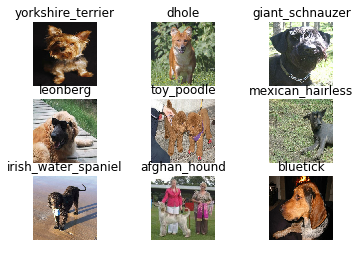

In [6]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = data_info.features["label"]
for i, (image, label) in enumerate(data.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

Augmentation could be a good way to go when you don't have enough sample sizes,here we do some random augmentations.

In [7]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

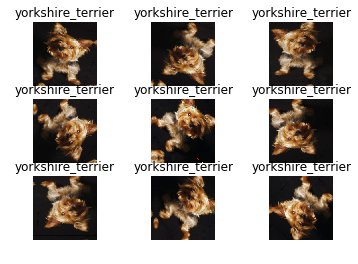

In [8]:
for image, label in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

# Implementation

Convert dataset to numpy array. Then separate original dataset into training set and testing set. The proportion of testing set is 0.3.

In [9]:
# preprocessing
data = Group14(sys='\\')  # '\\' for Windows and '/' for Mac
data.check()
files, breeds, breed_index = data.information()

In [10]:
# load data
x_train, x_test, y_train, y_test = data.load_data()

Build four models for implementation, including MLP, InceptionV3, ResNet50 and MobileNet. Then we do the model training and save each model. Since the training process may take a long time, we just present our training process by accuracy rate. In CPU enviornment, MLP takes about 2 hours for each epoch, InceptionV3 takes 7 minutes for each epoch, ResNet50 takes 1 hour for each epoch and MobileNet takes 20 minutes for each epoch.

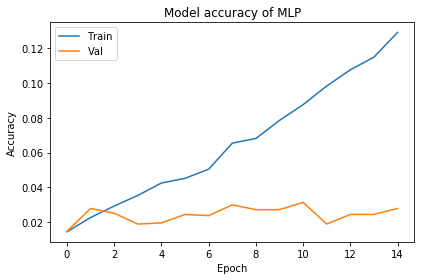

In [11]:
# MLP model
model_MLP, history_MLP = data.fit('MLP', epochs=15)
# model_MLP, history_MLP = data.load_model('MLP')
data.training_plot('MLP')

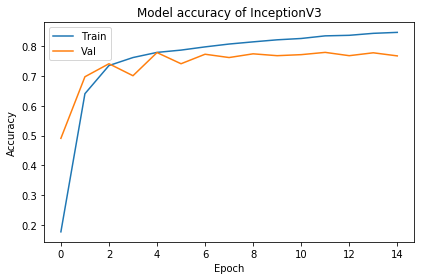

In [12]:
# InceptionV3 model
model_InceptionV3, history_InceptionV3 = data.fit('InceptionV3', epochs=15)
# model_InceptionV3, history_InceptionV3 = data.load_model('InceptionV3')
data.training_plot('InceptionV3')

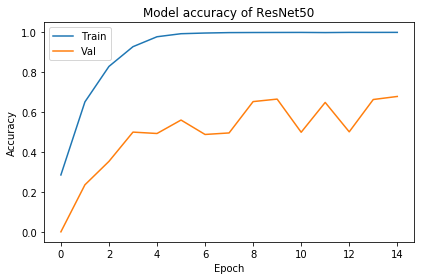

In [13]:
# pre-trained ResNet50 model
model_ResNet50, history_ResNet50 = data.fit('ResNet50', epochs=15)
# model_ResNet50, history_ResNet50 = data.load_model('ResNet50')
data.training_plot('ResNet50')

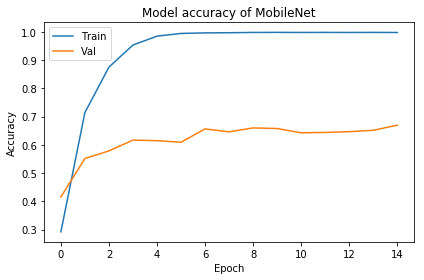

In [14]:
# pre_trained MobileNet model
model_MobileNet, history_MobileNet = data.fit('MobileNet', epochs=15)
# model_MobileNet, history_MobileNet = data.load_model('MobileNet')
data.training_plot('MobileNet')

Calculate prediction value in testing set.

In [15]:
# model evaluate
MLP_pre = data.model_evaluate('MLP')
InceptionV3_pre = data.model_evaluate('InceptionV3')
ResNet50_pre = data.model_evaluate('ResNet50')
MobileNet_pre = data.model_evaluate('MobileNet')

Evaluate the performance of each model.

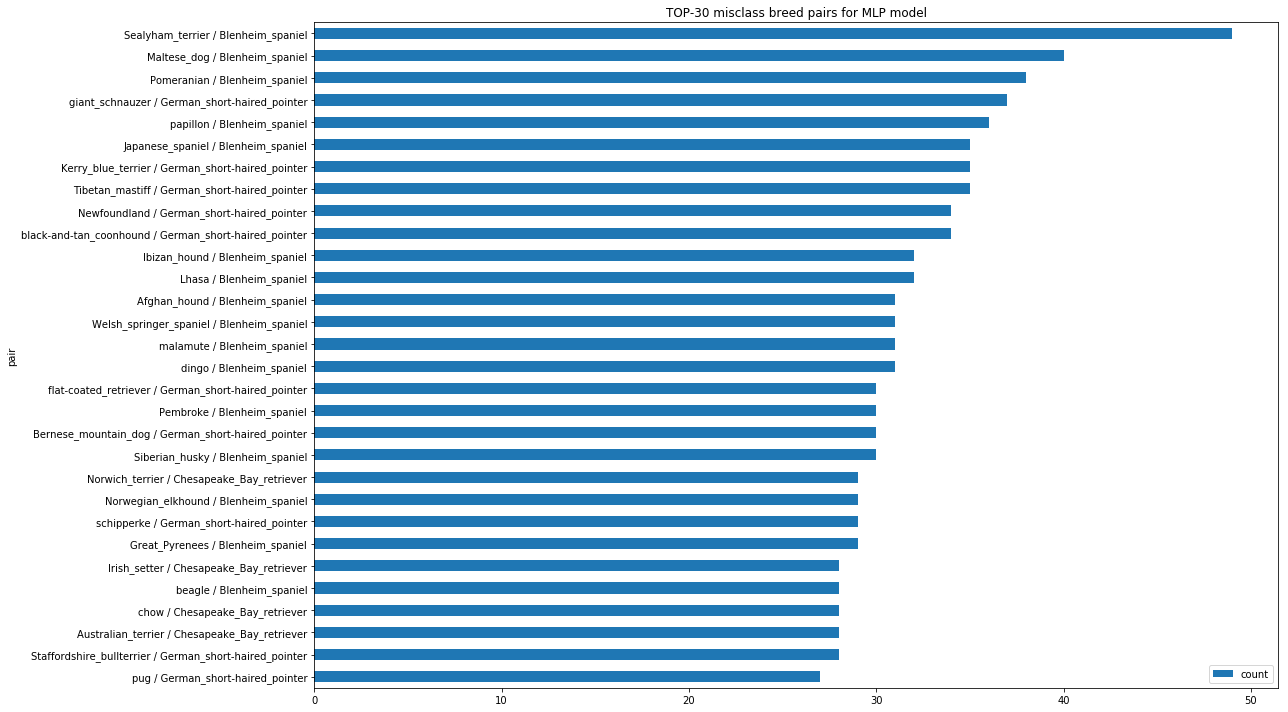

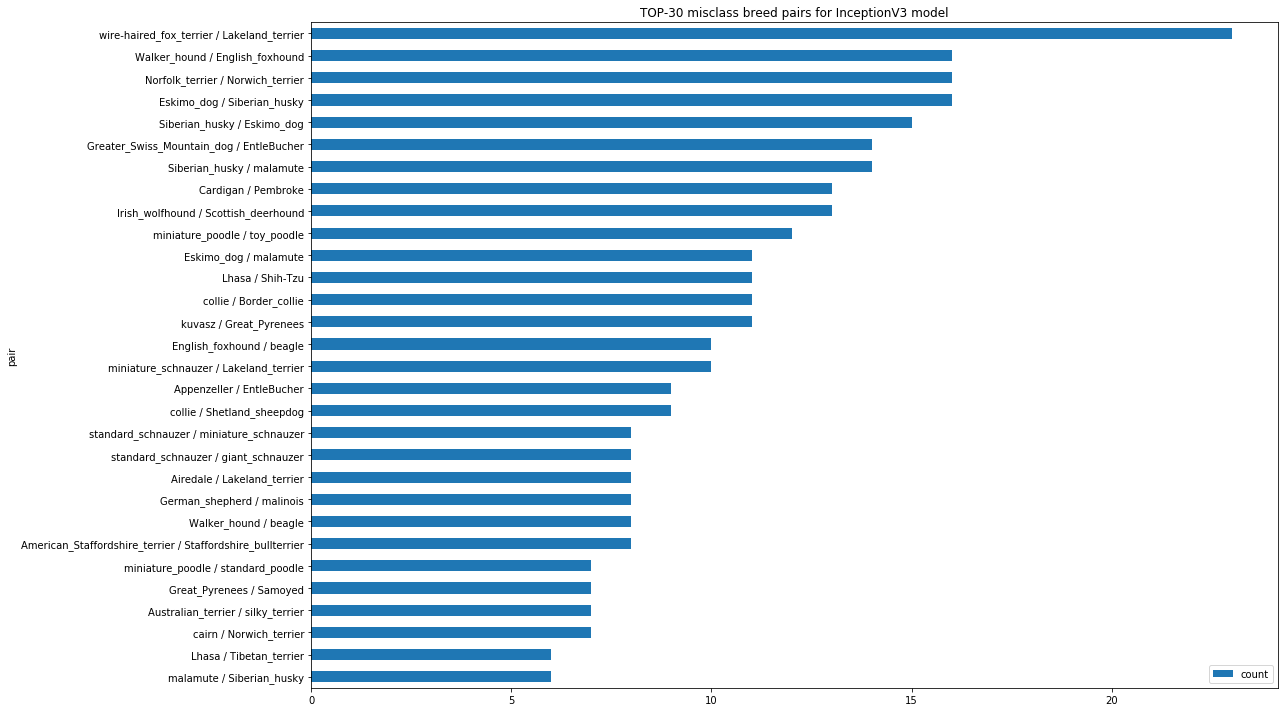

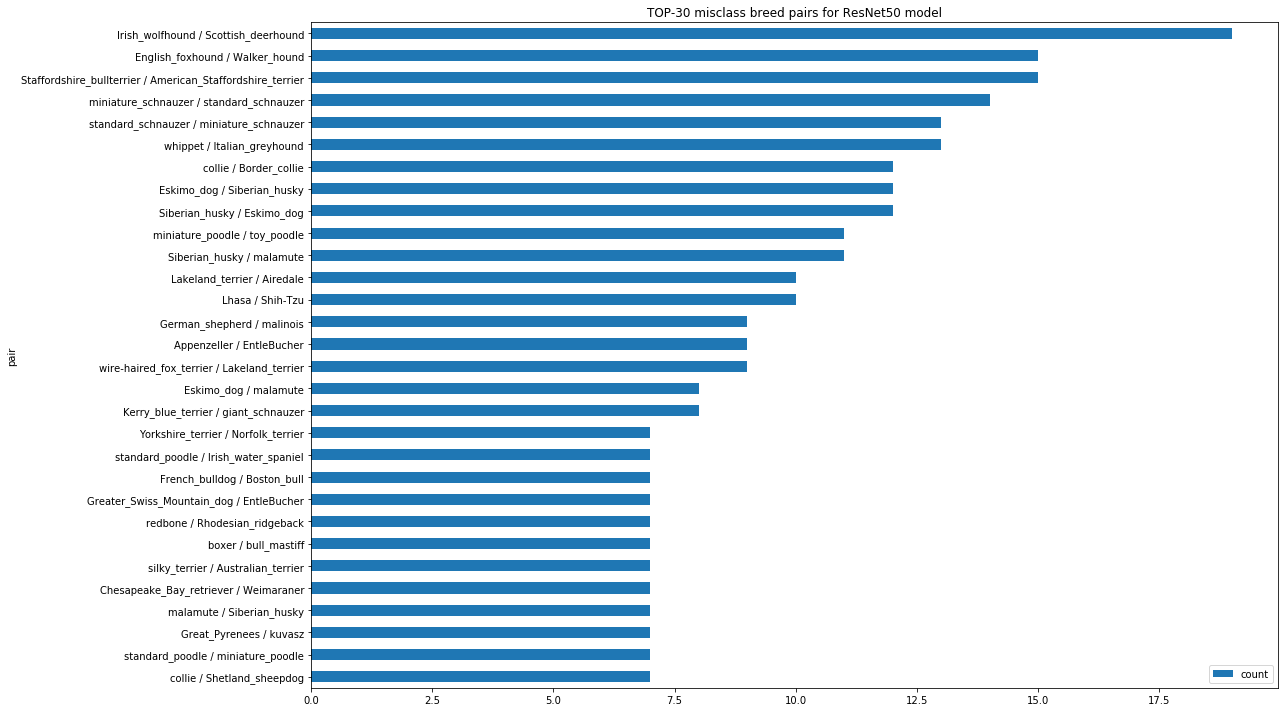

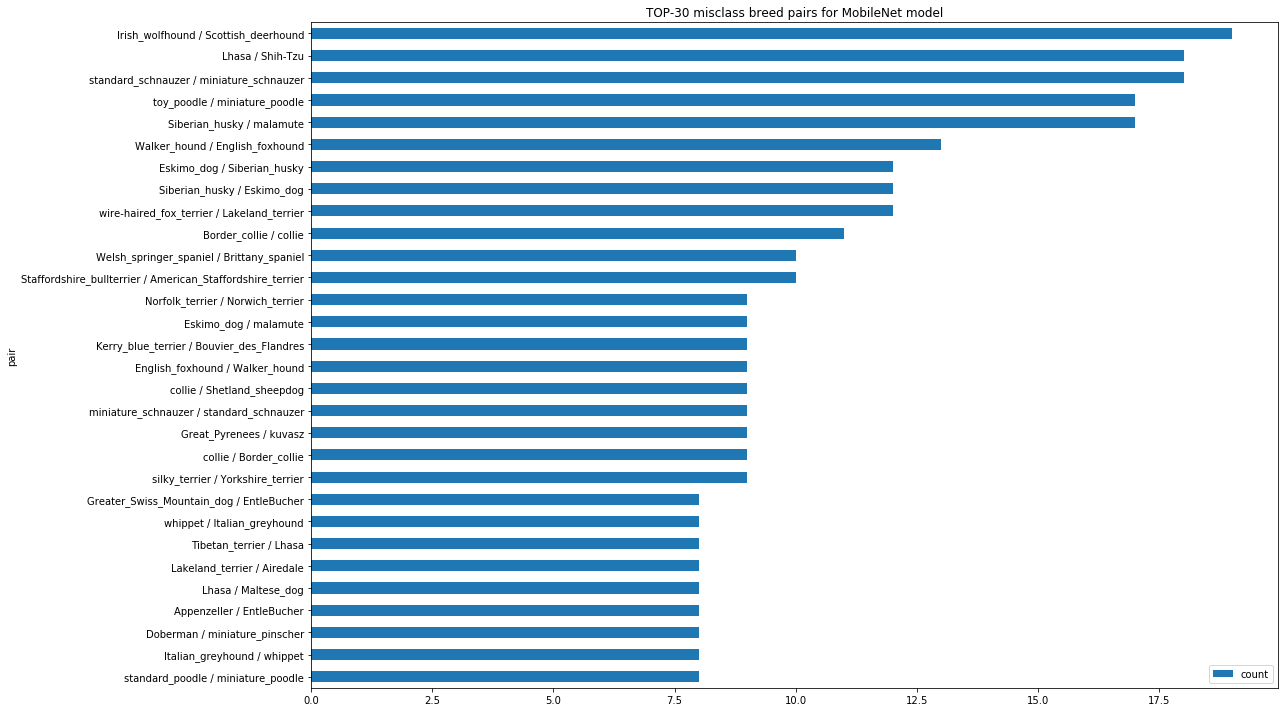

In [16]:
# result analysis
model_pre, model_result, breed_result = data.result()

Plot ROC curve for one breed.

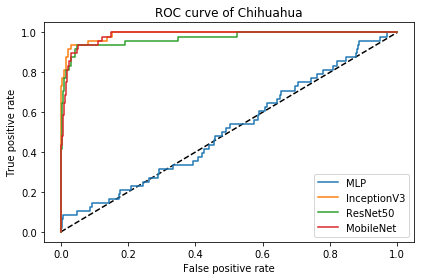

In [17]:
# plot ROC curve
data.roc_plot(breeds[0])

Plot confusion matrix heatmap for each model.

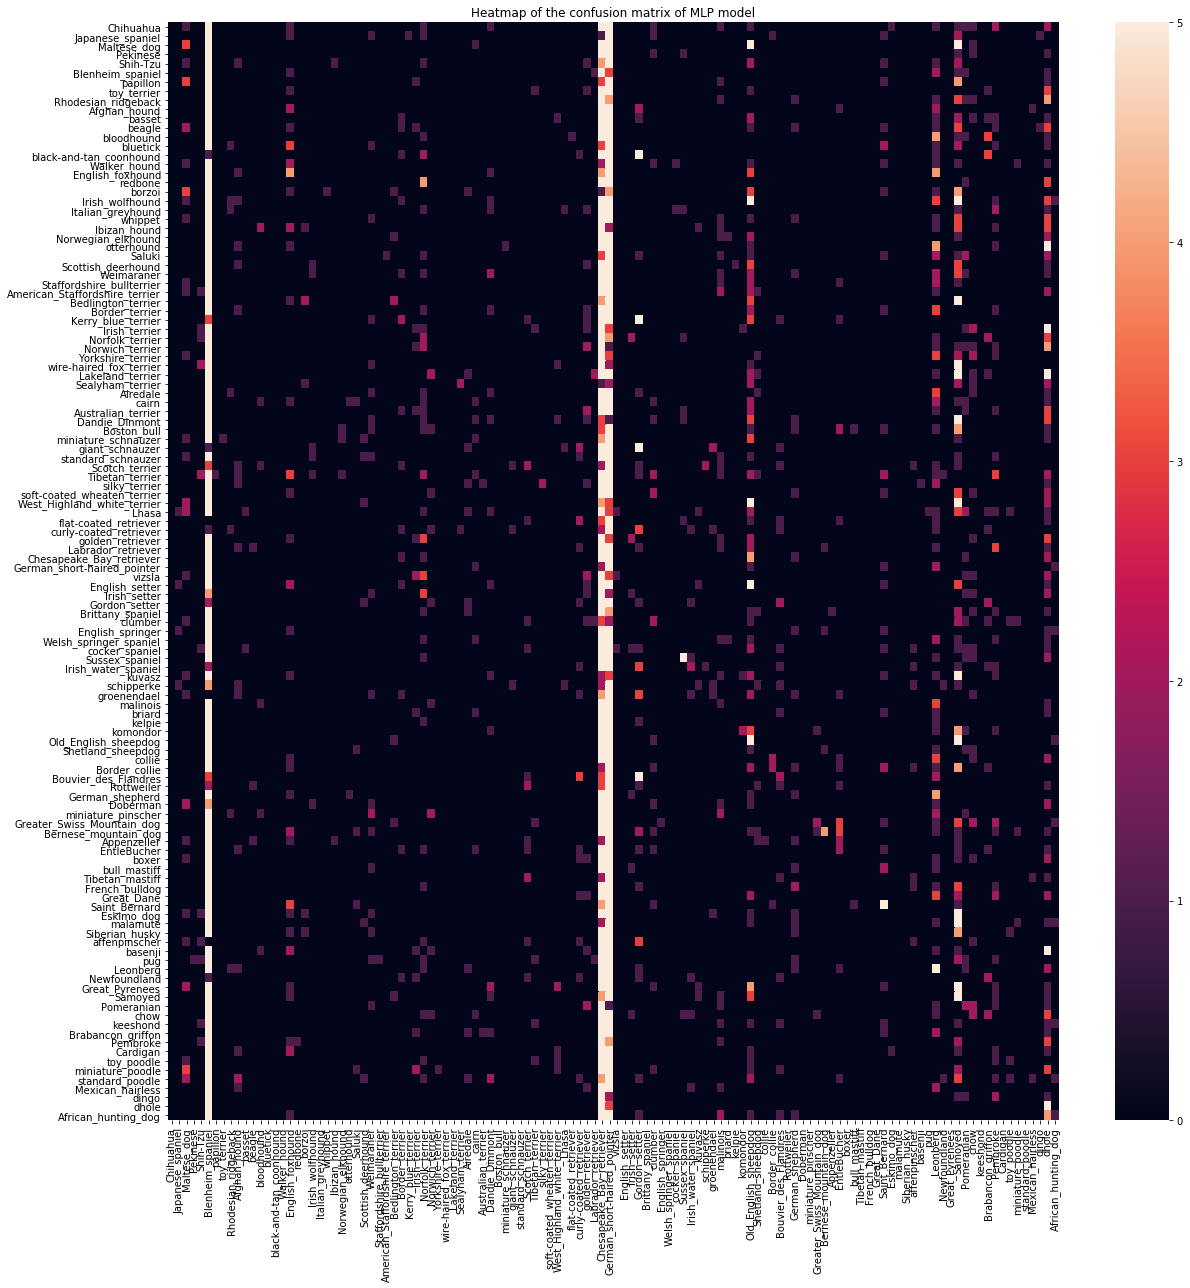

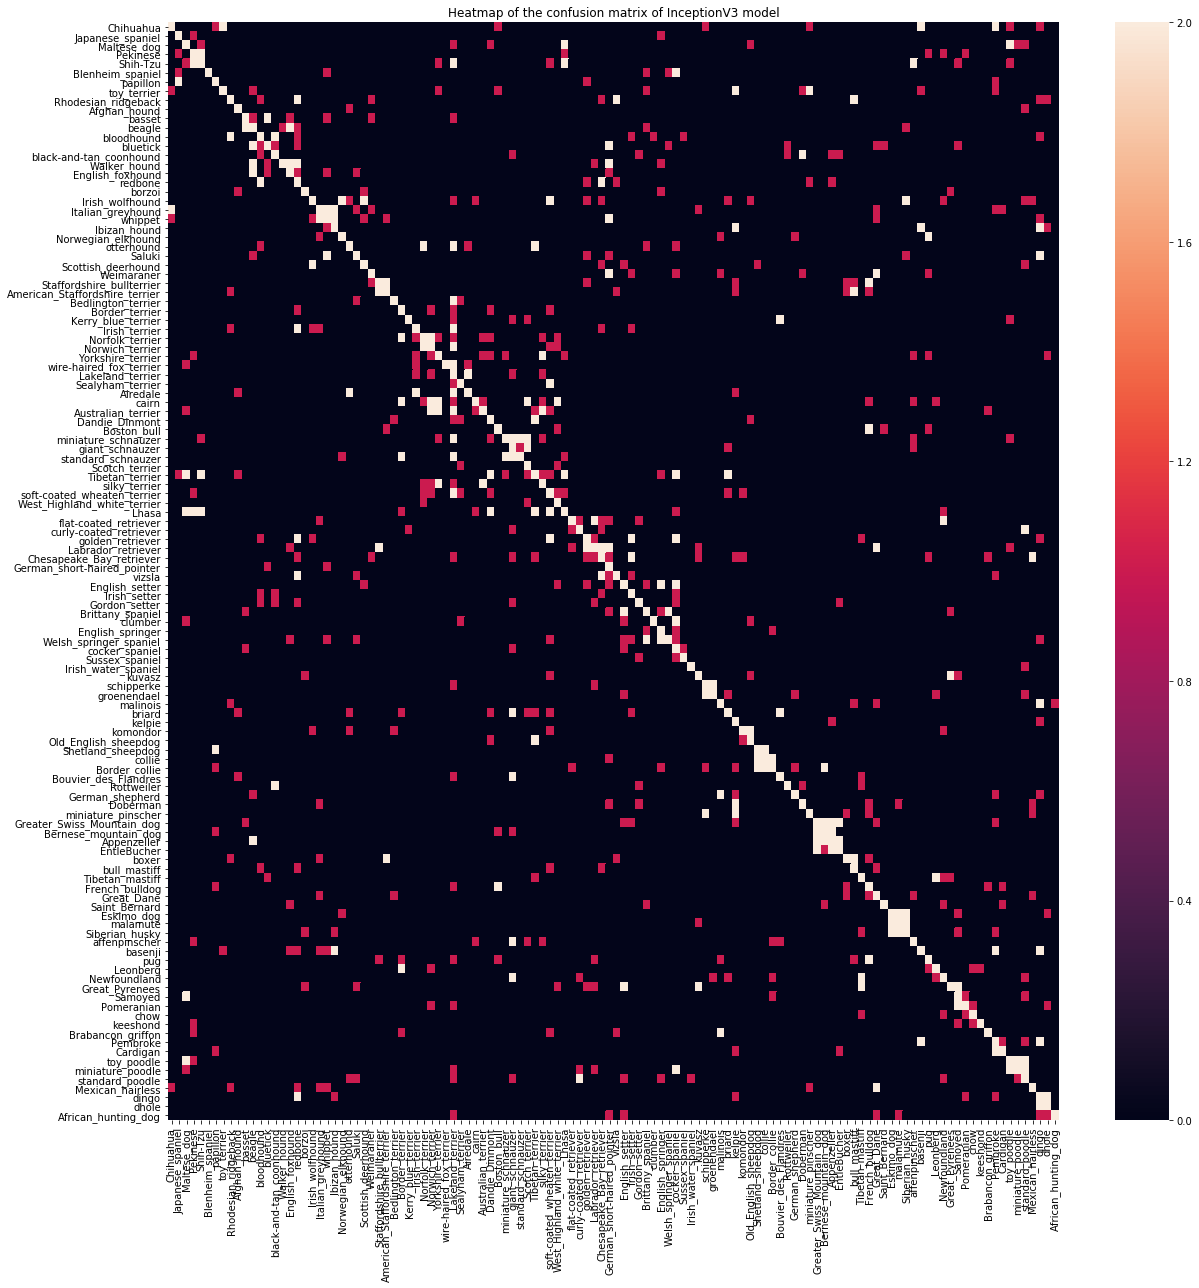

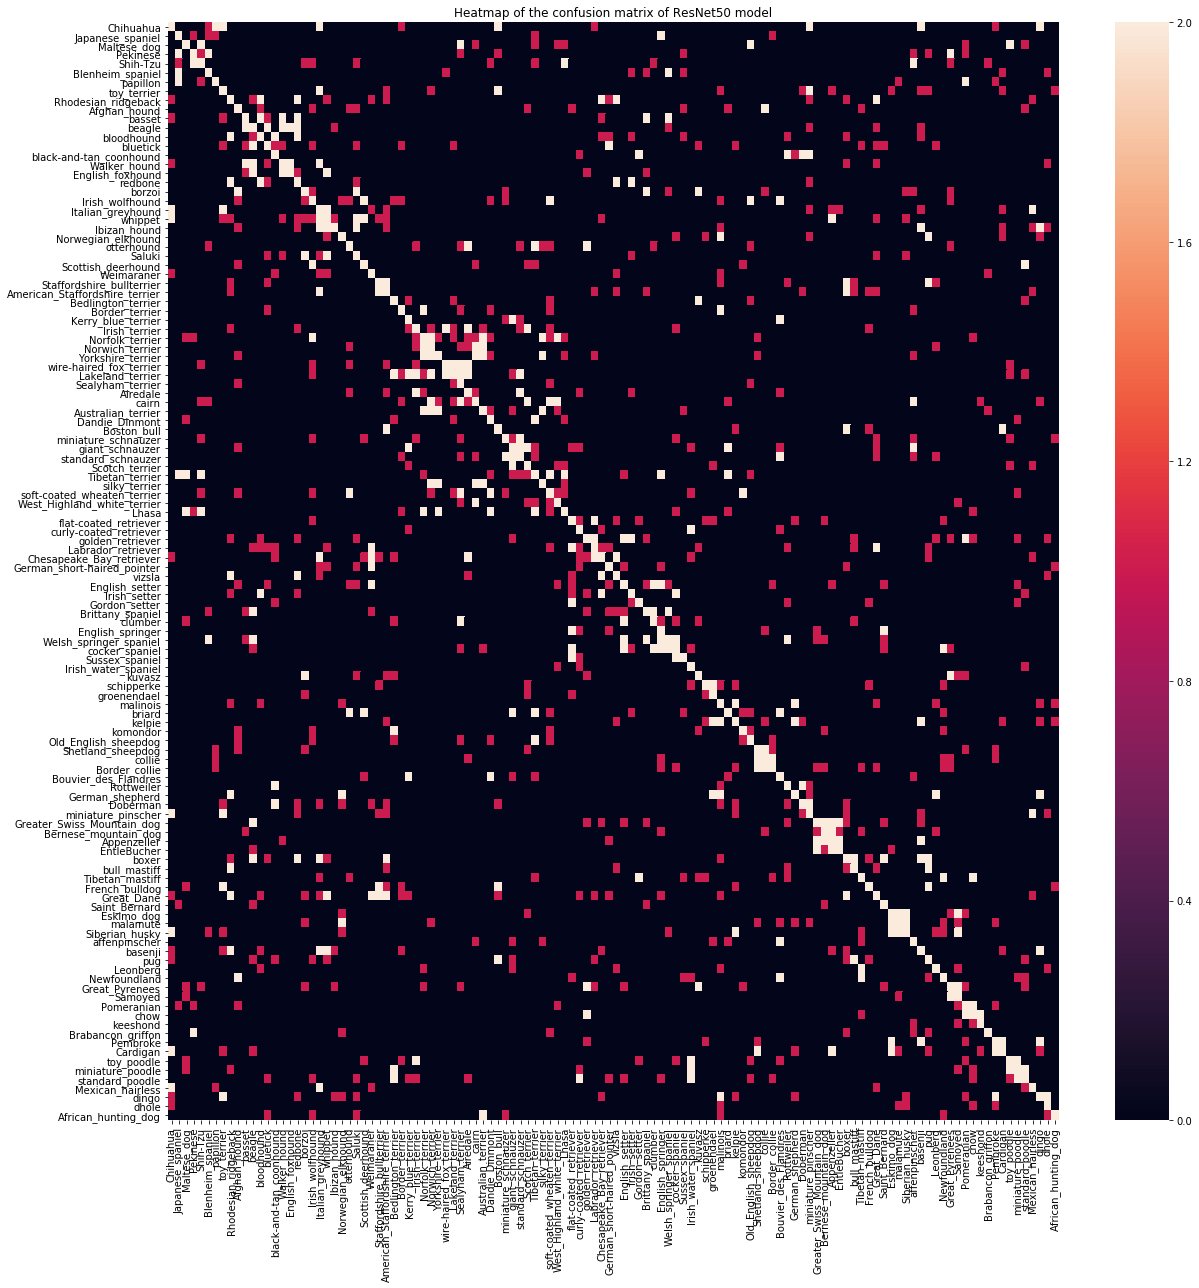

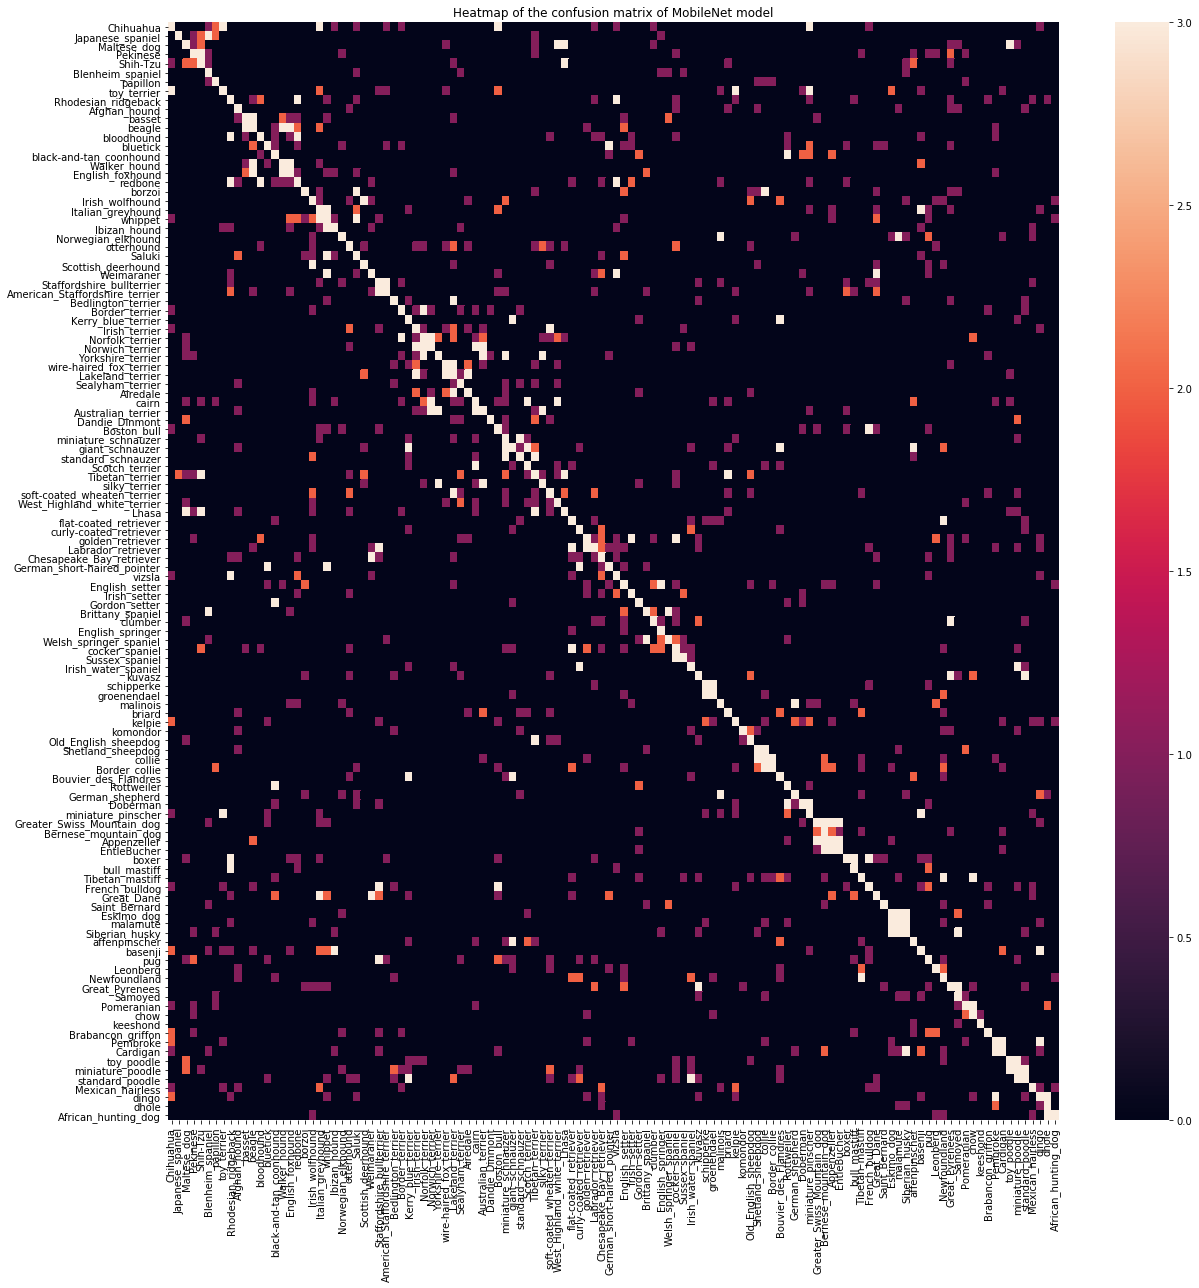

In [18]:
# plot confusion matrix heatmap
data.confusion_plot('MLP')
data.confusion_plot('InceptionV3')
data.confusion_plot('ResNet50')
data.confusion_plot('MobileNet')